In [1]:
data_root = 'data/blizzard'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from os.path import join
from tqdm import tqdm
import numpy as np
import h5py

In [3]:
f = h5py.File(join(data_root, 'samples.hdf5'), 'r')
dataset = f['samples']

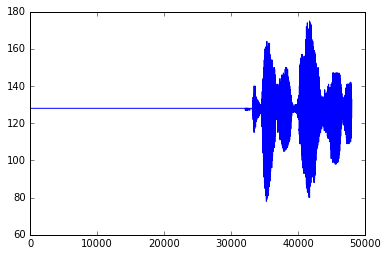

In [4]:
plt.plot(dataset[:3*16000])
plt.show()

In [5]:
from keras.layers import merge, Input
from keras.models import Model
from keras.layers.core import Dense, Activation
from keras.layers.convolutional import Convolution1D
from keras.layers.recurrent import LSTM

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [6]:
def generate_samples(data, batch_size, sample_length, discretize_input=False):
    sample_offset = 0
    step_size = sample_length + 1
    while True:
        if discretize_input:
            history = np.zeros((batch_size, sample_length, nb_classes), dtype='float32')
        else:
            history = np.zeros((batch_size, sample_length, 1), dtype='float32')
        predictions = np.zeros((batch_size, nb_classes), dtype='float32')
        for i in range(batch_size):
            if discretize_input:
                for j, k in enumerate(data[sample_offset:sample_offset+sample_length]):
                    history[i, j, k] = 1
            else:
                history[i] = data[sample_offset:sample_offset+sample_length].reshape(-1, 1)
            prediction = data[sample_offset+sample_length]
            predictions[i, prediction] = 1
            sample_offset = (sample_offset + step_size) % (data.shape[0] - step_size)
        if not discretize_input:
            history /= 255
        yield (history, predictions)

In [8]:
# check out an example batch, make sure the generator is sane
itr = generate_samples(dataset,
                       batch_size=3,
                       sample_length=2,
                       discretize_input=discretize_input)
for i in range(10000):
    X, y = next(itr)
X, y = next(itr)
print X.shape, y.shape
print X
print y

(3, 2, 256) (3, 256)
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  

In [7]:
discretize_input = True
use_residual = True
use_convolutions = True
lstm_activation = 'relu'
conv_activation = 'linear'

nb_classes = 256
sample_length = 256
features = 128
hidden_units = 128
layers = 7 # should be odd

if discretize_input:
    inputs = Input(shape=(sample_length, nb_classes))
else:
    inputs = Input(shape=(sample_length, 1))    
x = inputs

for i in range((layers - 1) / 2):
    x = LSTM(hidden_units, return_sequences=True)(x)
    x = Activation(lstm_activation)(x)
    if use_convolutions:
        x = Convolution1D(features, 1)(x)
        x = Activation(conv_activation)(x)
        
    y = LSTM(hidden_units, return_sequences=True)(x)
    y = Activation(lstm_activation)(y)
    if use_convolutions:
        y = Convolution1D(features, 1)(y)
        y = Activation(conv_activation)(y)
        
    if use_residual:
        x = merge([x, y], mode='sum')
    else:
        x = y
    
prediction = LSTM(nb_classes, activation='softmax', return_sequences=False)(x)

model = Model(input=inputs, output=prediction)
model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop')

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
input_1 (InputLayer)               (None, 256, 256)    0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                      (None, 256, 128)    197120      input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 256, 128)    0           lstm_1[0][0]                     
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 256, 128)    16512       activation_1[0][0]               
___________________________________________________________________________________________

In [ ]:
batch_size = 32
batches_per_epoch = 100

total_samples = len(dataset) / (sample_length + 1)
samples_per_epoch = batches_per_epoch * batch_size
epochs_per_real_epoch = total_samples / samples_per_epoch
print total_samples, 'samples in total'
print batch_size, 'batch_size'
print batches_per_epoch, 'batches_per_epoch'
print samples_per_epoch, 'samples_per_epoch'
print epochs_per_real_epoch, 'epochs for a full pass through the data'

model.fit_generator(generate_samples(dataset, batch_size, sample_length, discretize_input),
                   samples_per_epoch=samples_per_epoch,
                   nb_epoch=epochs_per_real_epoch)

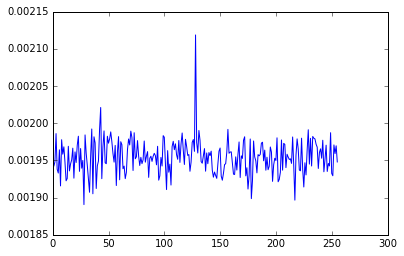

In [25]:
itr = generate_samples(dataset, 1, sample_length, discretize_input)
X, y = next(itr)
prediction = model.predict(X)
plt.plot(prediction.flat)
plt.show()